In [54]:
import os
import json
import re
import matplotlib.pyplot as plt




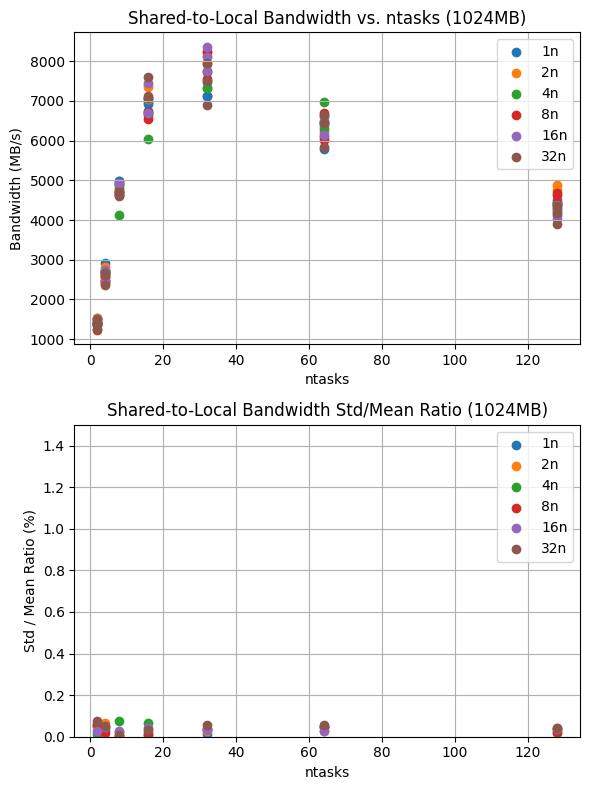

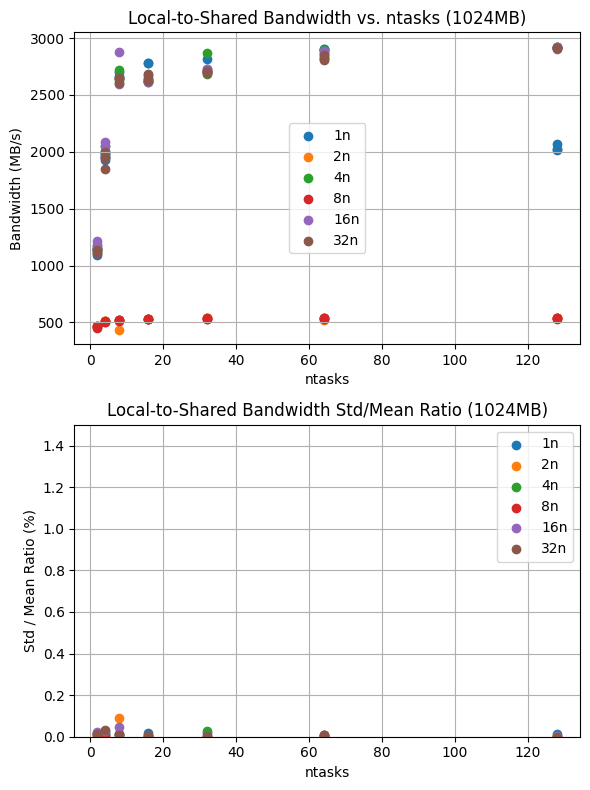

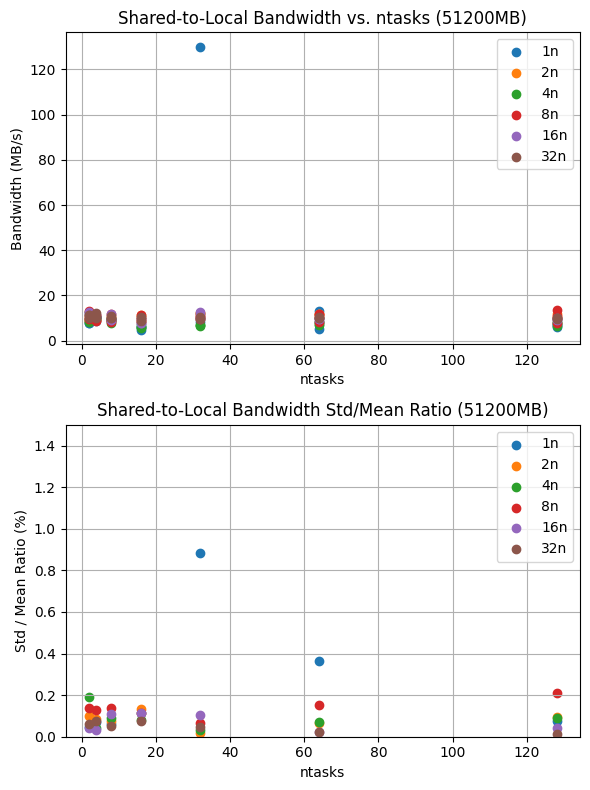

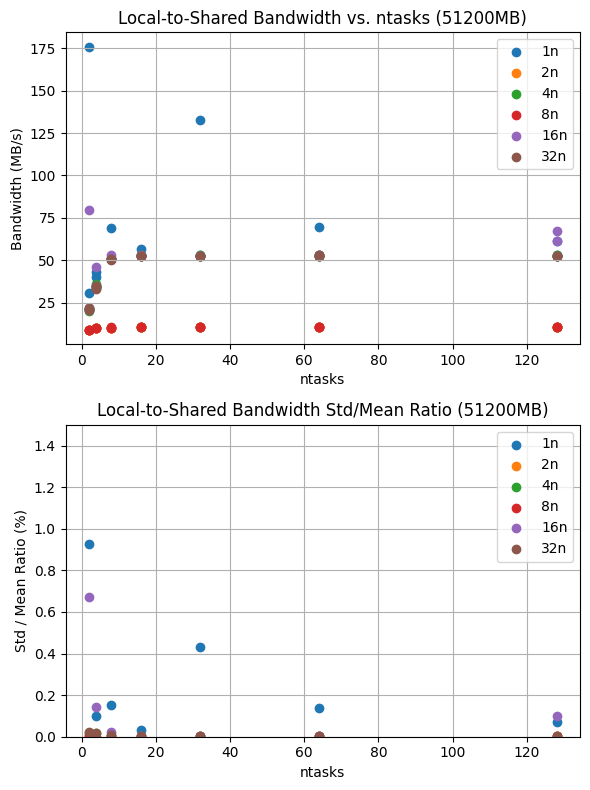

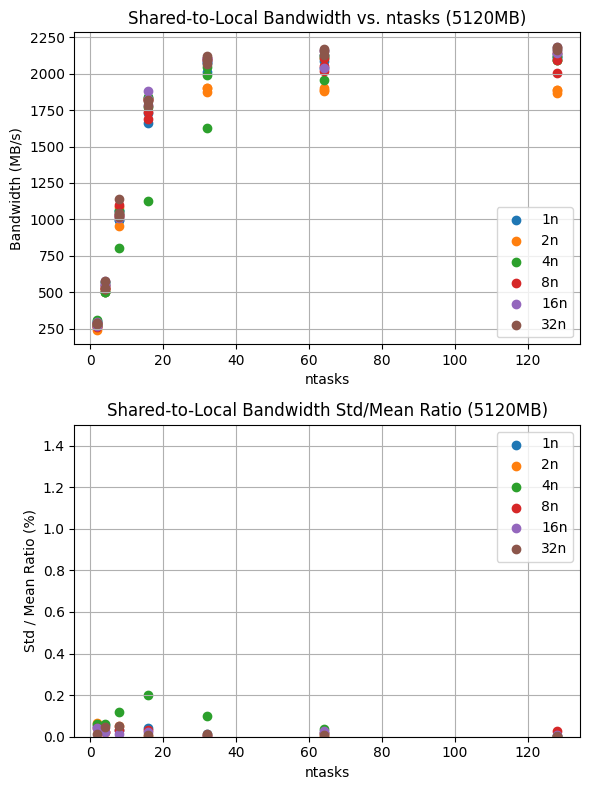

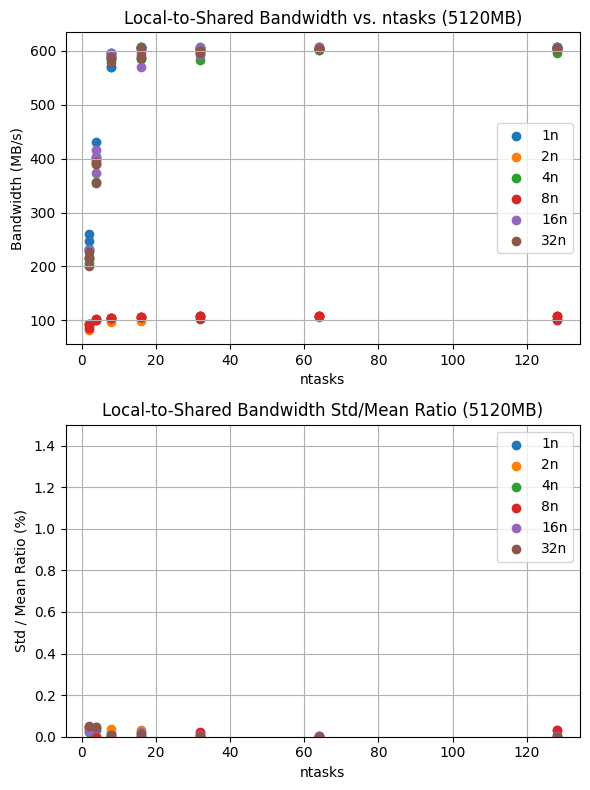

In [55]:
# /home/tang584/scripts/linux_resource_detect/update_average_values.py

import os
import re
import json
import matplotlib.pyplot as plt

filenames = [f for f in os.listdir() if f.startswith("PFS_to_SSD_") and f.endswith(".out")]
data = {}

for filename in filenames:
    match = re.search(r'_(\d+)n_', filename)
    if not match:
        continue
    node_count = int(match.group(1))
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('{'):
                record = json.loads(line)
                filesize = record.get("filesize")
                if not filesize:
                    continue
                if filesize not in data:
                    data[filesize] = {}
                if node_count not in data[filesize]:
                    data[filesize][node_count] = {"ntasks": [], "shared-to-local": [], "local-to-share": []}
                for trial_key, entry in record.items():
                    if trial_key == "filesize":
                        continue
                    data[filesize][node_count]["ntasks"].append(entry["ntasks"])
                    data[filesize][node_count]["shared-to-local"].append(entry["shared-to-local-bw(MB/s)"])
                    data[filesize][node_count]["local-to-share"].append(entry["local-to-share-bw(MB/s)"])

# Calculate averages and standard deviations
import numpy as np
averages = {}
std_devs = {}
for filesize, nodes in data.items():
    averages[filesize] = {}
    std_devs[filesize] = {}
    for node_count, metrics in nodes.items():
        averages[filesize][node_count] = {
            "shared-to-local": np.mean(metrics["shared-to-local"]) if metrics["shared-to-local"] else 0,
            "local-to-share": np.mean(metrics["local-to-share"]) if metrics["local-to-share"] else 0,
        }
        std_devs[filesize][node_count] = {
            "shared-to-local": (100 * np.std(metrics["shared-to-local"])/np.mean(metrics["shared-to-local"])) if metrics["shared-to-local"] else 0,
            "local-to-share": (100 * np.std(metrics["local-to-share"])/np.mean(metrics["local-to-share"])) if metrics["local-to-share"] else 0,
        }

for filesize in sorted(data.keys()):
    # Plot shared-to-local: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["shared-to-local"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Shared-to-Local Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    # for node in sorted(data[filesize].keys()):
    #     unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
    #     std_values = []
    #     for ntask in unique_ntasks:
    #         indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
    #         std_values.append(np.std([data[filesize][node]["shared-to-local"][i] for i in indices]))
    #     ax2.scatter(unique_ntasks, std_values, label=f"{node}n")
    # ax2.set_xlabel("ntasks")
    # ax2.set_ylabel("Standard Deviation")
    # ax2.set_title(f"Shared-to-Local Bandwidth Standard Deviation ({filesize})")
    # ax2.legend()
    # ax2.grid(True)
    # ax2.set_ylim(0, 50000)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["shared-to-local"][i] for i in indices]
            std_ratio = np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Shared-to-Local Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 1.5)

    plt.tight_layout()

    # Plot local-to-share: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["local-to-share"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Local-to-Shared Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    # for node in sorted(data[filesize].keys()):
    #     unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
    #     std_values = []
    #     for ntask in unique_ntasks:
    #         indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
    #         std_values.append(np.std([data[filesize][node]["local-to-share"][i] for i in indices]))
    #     ax2.scatter(unique_ntasks, std_values, label=f"{node}n")
    # ax2.set_xlabel("ntasks")
    # ax2.set_ylabel("Standard Deviation")
    # ax2.set_title(f"Local-to-Shared Bandwidth Standard Deviation ({filesize})")
    # ax2.legend()
    # ax2.grid(True)
    # ax2.set_ylim(0, 50000)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["local-to-share"][i] for i in indices]
            std_ratio = np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Local-to-Shared Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 1.5)

    plt.tight_layout()

In [56]:
print(data)

{'1024MB': {1: {'ntasks': [2, 4, 8, 16, 32, 64, 128, 2, 4, 8, 16, 32, 64, 128, 2, 4, 4, 16, 32, 64, 128], 'shared-to-local': [1544.56, 2724.01, 4972.14, 6977.55, 7126.08, 6448.63, 4502.8, 1376.75, 2672.2, 4993.48, 6911.79, 7315.11, 6493.89, 4285.49, 1403.2, 2911.29, 2724.01, 6743.3, 7138.16, 5786.15, 4136.24], 'local-to-share': [1095.59, 1981.16, 2702.18, 2783.42, 2710.11, 2902.72, 2015.75, 1133.9, 1954.2, 2663.34, 2671.32, 2728.68, 2895.52, 2065.66, 1147.58, 1930.86, 1981.16, 2783.01, 2815.33, 2907.89, 2023.97]}, 16: {'ntasks': [2, 4, 8, 16, 32, 64, 128, 2, 4, 8, 16, 32, 64, 128, 2, 4, 8, 16, 32, 64, 128], 'shared-to-local': [1392.75, 2462.0, 4624.02, 6692.21, 8102.76, 6148.03, 4372.79, 1489.02, 2669.66, 4901.98, 7455.61, 8372.83, 6435.07, 4301.09, 1470.31, 2743.72, 4938.87, 7085.88, 7749.25, 6591.75, 4021.11], 'local-to-share': [1216.35, 2053.64, 2879.74, 2621.59, 2699.97, 2836.0, 2903.96, 1180.09, 2084.86, 2593.3, 2617.66, 2710.57, 2882.58, 2925.49, 1157.82, 1953.51, 2645.3, 2627.25

In [57]:
import pandas as pd

IOR_PARAMS = [
    'operation', 'randomOffset', 'transferSize', 
    'aggregateFilesizeMB', 'numTasks', 'totalTime', 
    'numNodes', 'tasksPerNode', 'parallelism', 'trMiB', "storageType"
]

rows = []

for filesize, nodes in data.items():
    filesize_mb = int(filesize.replace("MB", ""))
    for num_nodes, metrics in nodes.items():
        ntasks_list = metrics['ntasks']
        shared_bw_list = metrics['shared-to-local']
        local_bw_list = metrics['local-to-share']
        for i in range(len(ntasks_list)):
            ntasks = ntasks_list[i]
            # Shared-to-local (read)
            rows.append({
                'operation': 'read',
                'randomOffset': None,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': None,
                'trMiB': shared_bw_list[i],
                'storageType': 'beegfs-ssd'
            })
            # Local-to-shared (write)
            rows.append({
                'operation': 'write',
                'randomOffset': None,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': None,
                'trMiB': local_bw_list[i],
                'storageType': 'ssd-beegfs'
            })
            
data_df = pd.DataFrame(rows, columns=IOR_PARAMS)

print(data_df.head(5))

  operation randomOffset  transferSize  aggregateFilesizeMB  numTasks  \
0      read         None          4096                 1024         2   
1     write         None          4096                 1024         2   
2      read         None          4096                 1024         4   
3     write         None          4096                 1024         4   
4      read         None          4096                 1024         8   

   totalTime  numNodes  tasksPerNode parallelism    trMiB storageType  
0         -1         1             2        None  1544.56  beegfs-ssd  
1         -1         1             2        None  1095.59  ssd-beegfs  
2         -1         1             4        None  2724.01  beegfs-ssd  
3         -1         1             4        None  1981.16  ssd-beegfs  
4         -1         1             8        None  4972.14  beegfs-ssd  


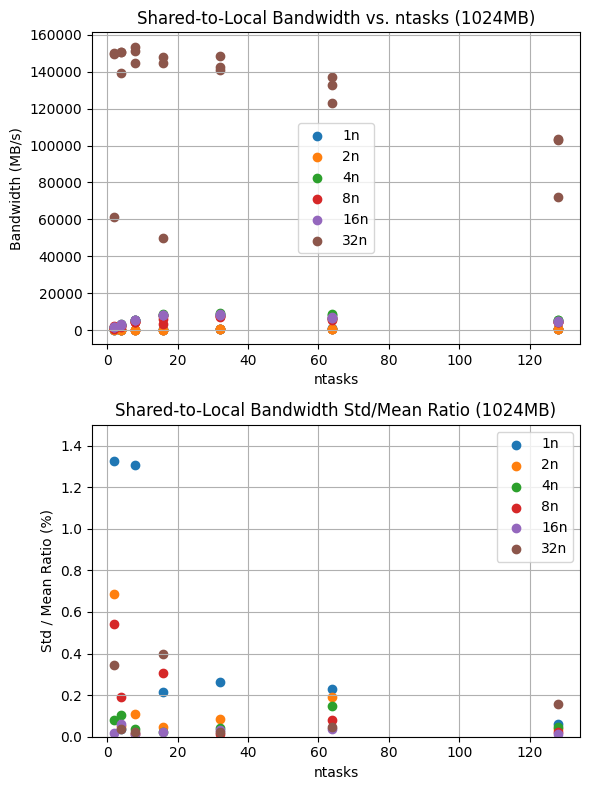

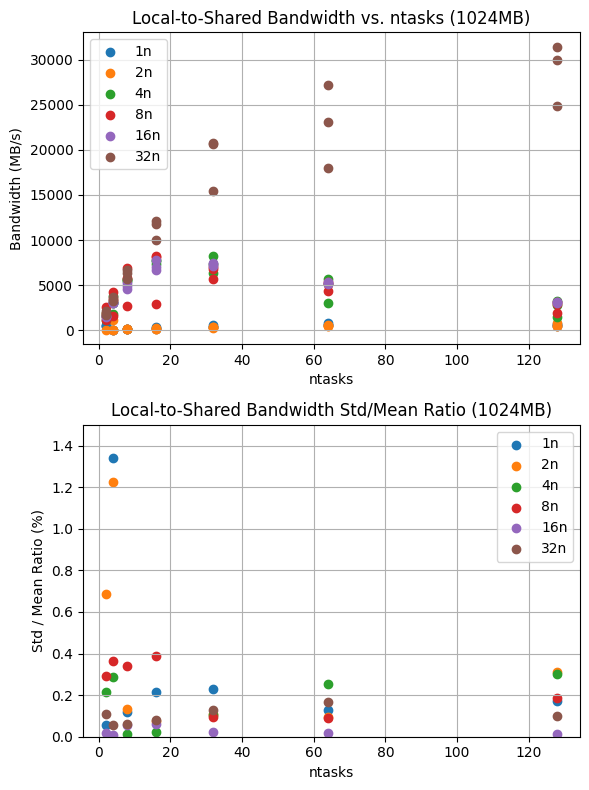

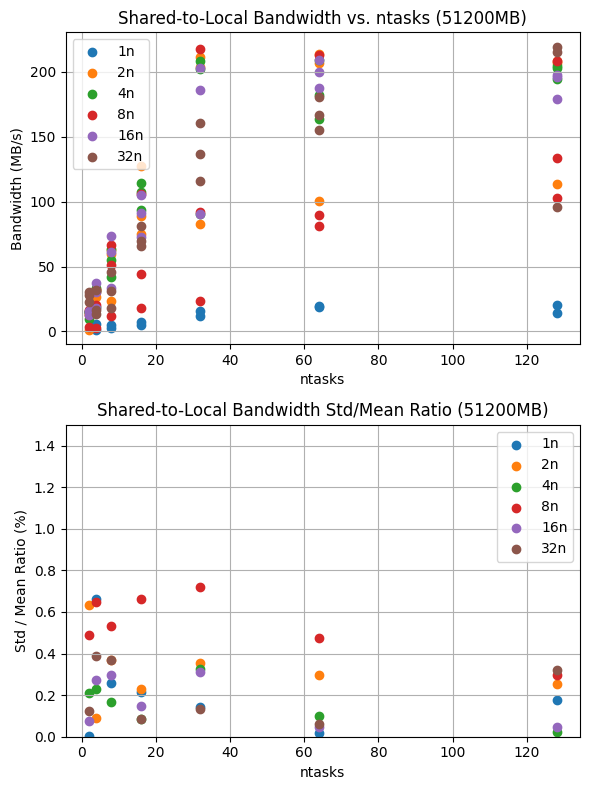

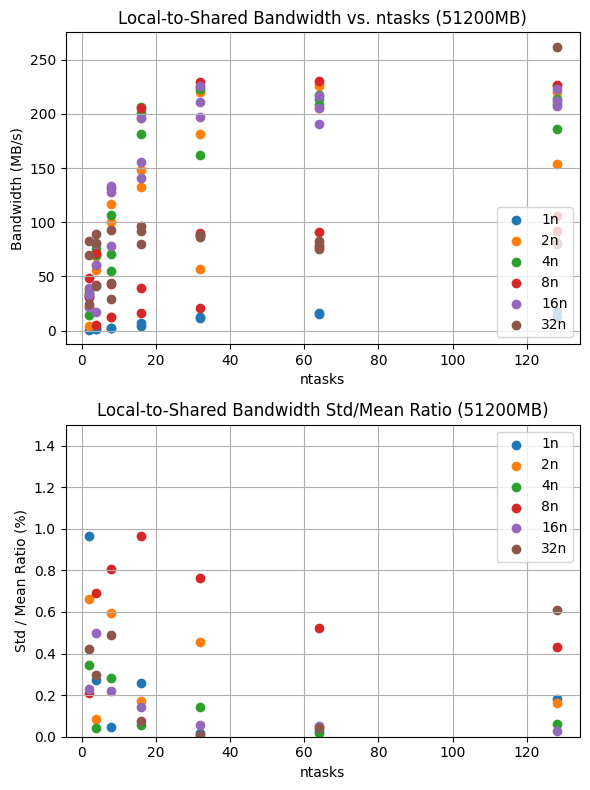

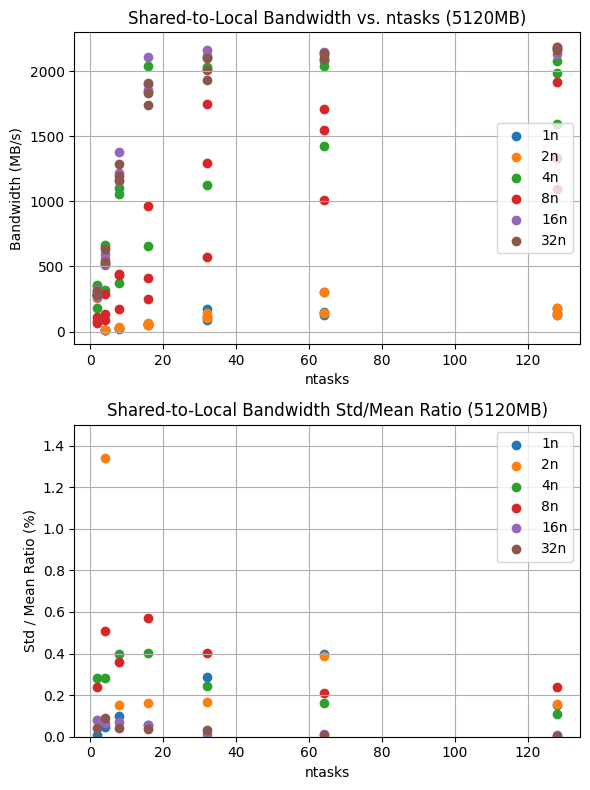

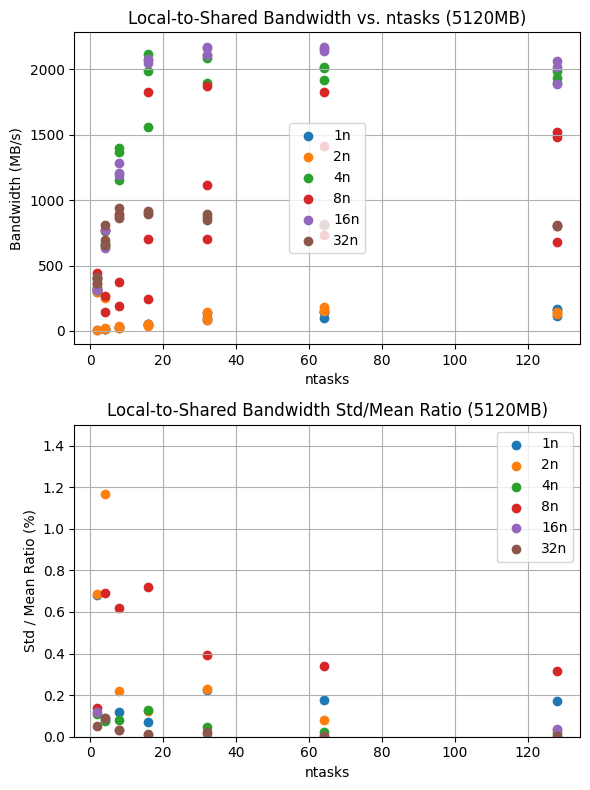

In [58]:
# /home/tang584/scripts/linux_resource_detect/update_average_values.py

import os
import re
import json
import matplotlib.pyplot as plt

filenames = [f for f in os.listdir() if f.startswith("PFS_to_tmpfs_") and f.endswith(".out")]
data = {}

for filename in filenames:
    match = re.search(r'_(\d+)n_', filename)
    if not match:
        continue
    node_count = int(match.group(1))
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('{'):
                record = json.loads(line)
                filesize = record.get("filesize")
                if not filesize:
                    continue
                if filesize not in data:
                    data[filesize] = {}
                if node_count not in data[filesize]:
                    data[filesize][node_count] = {"ntasks": [], "shared-to-local": [], "local-to-share": []}
                for trial_key, entry in record.items():
                    if trial_key == "filesize":
                        continue
                    data[filesize][node_count]["ntasks"].append(entry["ntasks"])
                    data[filesize][node_count]["shared-to-local"].append(entry["shared-to-local-bw(MB/s)"])
                    data[filesize][node_count]["local-to-share"].append(entry["local-to-share-bw(MB/s)"])

# Calculate averages and standard deviations
import numpy as np
averages = {}
std_devs = {}
for filesize, nodes in data.items():
    averages[filesize] = {}
    std_devs[filesize] = {}
    for node_count, metrics in nodes.items():
        averages[filesize][node_count] = {
            "shared-to-local": np.mean(metrics["shared-to-local"]) if metrics["shared-to-local"] else 0,
            "local-to-share": np.mean(metrics["local-to-share"]) if metrics["local-to-share"] else 0,
        }
        std_devs[filesize][node_count] = {
            "shared-to-local": np.std(metrics["shared-to-local"])/np.mean(metrics["shared-to-local"]) if metrics["shared-to-local"] else 0,
            "local-to-share": np.std(metrics["local-to-share"])/np.mean(metrics["local-to-share"]) if metrics["local-to-share"] else 0,
        }

# Plotting
for filesize in sorted(data.keys()):
    # Plot shared-to-local: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["shared-to-local"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Shared-to-Local Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    for node in sorted(data[filesize].keys()):
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        std_values = []
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            std_values.append(np.std([data[filesize][node]["shared-to-local"][i] for i in indices]))
        ax2.scatter(unique_ntasks, std_values, label=f"{node}n")
    ax2.set_xlabel("ntasks")
    ax2.set_ylabel("Standard Deviation")
    ax2.set_title(f"Shared-to-Local Bandwidth Standard Deviation ({filesize})")
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, 50000)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["shared-to-local"][i] for i in indices]
            std_ratio = np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Shared-to-Local Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 1.5)

    plt.tight_layout()

    # Plot local-to-share: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["local-to-share"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Local-to-Shared Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    # for node in sorted(data[filesize].keys()):
    #     unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
    #     std_values = []
    #     for ntask in unique_ntasks:
    #         indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
    #         std_values.append(np.std([data[filesize][node]["local-to-share"][i] for i in indices]))
    #     ax2.scatter(unique_ntasks, std_values, label=f"{node}n")
    # ax2.set_xlabel("ntasks")
    # ax2.set_ylabel("Standard Deviation")
    # ax2.set_title(f"Local-to-Shared Bandwidth Standard Deviation ({filesize})")
    # ax2.legend()
    # ax2.grid(True)
    # ax2.set_ylim(0, 50000)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["local-to-share"][i] for i in indices]
            std_ratio = np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Local-to-Shared Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 1.5)

    plt.tight_layout()

In [59]:
import pandas as pd

IOR_PARAMS = [
    'operation', 'randomOffset', 'transferSize', 
    'aggregateFilesizeMB', 'numTasks', 'totalTime', 
    'numNodes', 'tasksPerNode', 'parallelism', 'trMiB', "storageType"
]

rows = []

for filesize, nodes in data.items():
    filesize_mb = int(filesize.replace("MB", ""))
    for num_nodes, metrics in nodes.items():
        ntasks_list = metrics['ntasks']
        shared_bw_list = metrics['shared-to-local']
        local_bw_list = metrics['local-to-share']
        for i in range(len(ntasks_list)):
            ntasks = ntasks_list[i]
            # Shared-to-local (read)
            rows.append({
                'operation': 'read',
                'randomOffset': None,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': None,
                'trMiB': shared_bw_list[i],
                'storageType': 'beegfs-tmpfs'
            })
            # Local-to-shared (write)
            rows.append({
                'operation': 'write',
                'randomOffset': None,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': None,
                'trMiB': local_bw_list[i],
                'storageType': 'tmpfs-beegfs'
            })
            
# data_df = pd.DataFrame(rows, columns=IOR_PARAMS)
data_df = pd.concat([data_df, pd.DataFrame(rows, columns=IOR_PARAMS)], ignore_index=True)


print(data_df.head(5))

  operation randomOffset  transferSize  aggregateFilesizeMB  numTasks  \
0      read         None          4096                 1024         2   
1     write         None          4096                 1024         2   
2      read         None          4096                 1024         4   
3     write         None          4096                 1024         4   
4      read         None          4096                 1024         8   

   totalTime  numNodes  tasksPerNode parallelism    trMiB storageType  
0         -1         1             2        None  1544.56  beegfs-ssd  
1         -1         1             2        None  1095.59  ssd-beegfs  
2         -1         1             4        None  2724.01  beegfs-ssd  
3         -1         1             4        None  1981.16  ssd-beegfs  
4         -1         1             8        None  4972.14  beegfs-ssd  


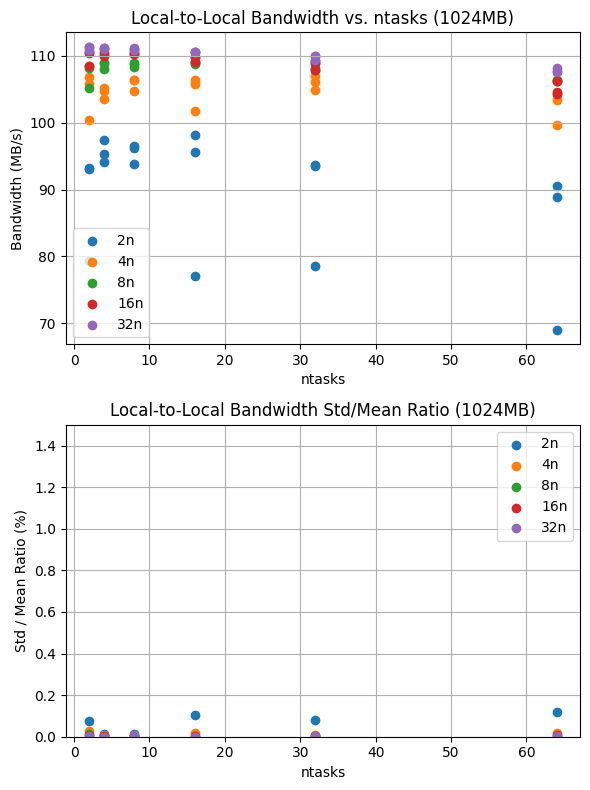

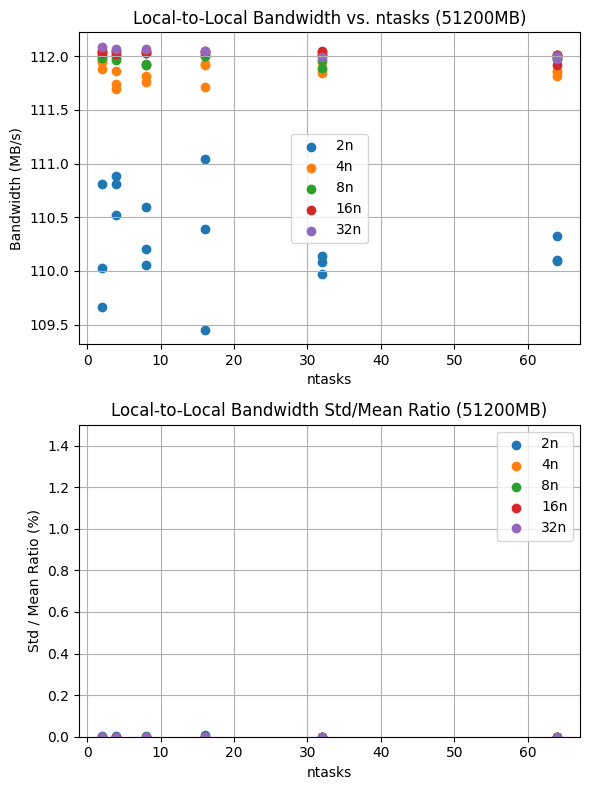

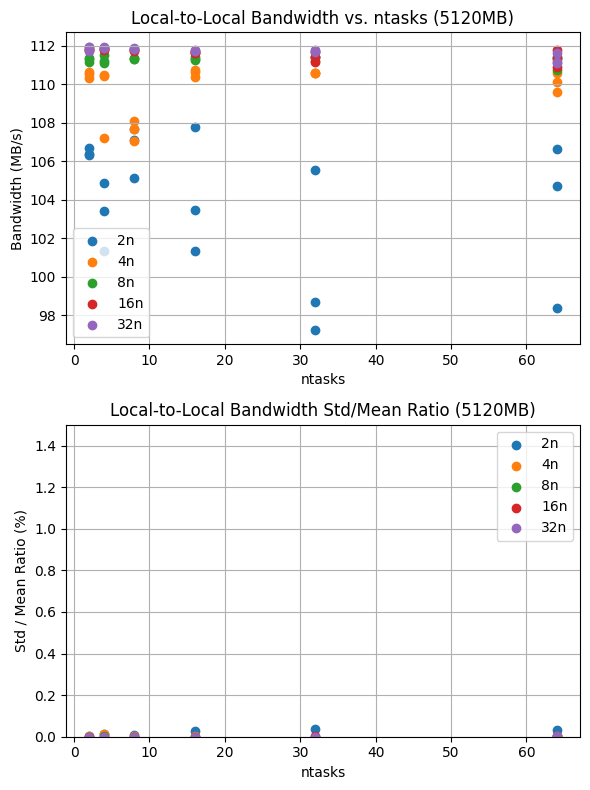

In [60]:
# /home/tang584/scripts/linux_resource_detect/update_average_values.py

import os
import re
import json
import matplotlib.pyplot as plt

filenames = [f for f in os.listdir() if f.startswith("SSD_to_SSD_") and f.endswith(".out")]
data = {}

for filename in filenames:
    match = re.search(r'_(\d+)n_', filename)
    if not match:
        continue
    node_count = int(match.group(1))
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('{'):
                record = json.loads(line)
                filesize = record.get("filesize")
                if not filesize:
                    continue
                if filesize not in data:
                    data[filesize] = {}
                if node_count not in data[filesize]:
                    data[filesize][node_count] = {"ntasks": [], "local-to-local": []}
                for trial_key, entry in record.items():
                    if trial_key == "filesize":
                        continue
                    data[filesize][node_count]["ntasks"].append(entry["ntasks"])
                    data[filesize][node_count]["local-to-local"].append(entry["local-to-local-bw(MB/s)"])

# Calculate averages and standard deviations
import numpy as np
averages = {}
std_devs = {}
for filesize, nodes in data.items():
    averages[filesize] = {}
    std_devs[filesize] = {}
    for node_count, metrics in nodes.items():
        averages[filesize][node_count] = {
            "local-to-local": np.mean(metrics["local-to-local"]) if metrics["local-to-local"] else 0,
        }
        std_devs[filesize][node_count] = {
            "local-to-local": np.std(metrics["local-to-local"])/np.mean(metrics["local-to-local"]) if metrics["local-to-local"] else 0,
        }

# Plotting
for filesize in sorted(data.keys()):
    # Plot shared-to-local: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["local-to-local"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Local-to-Local Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    # for node in sorted(data[filesize].keys()):
    #     unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
    #     std_values = []
    #     for ntask in unique_ntasks:
    #         indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
    #         std_values.append(np.std([data[filesize][node]["local-to-local"][i] for i in indices]))
    #     ax2.scatter(unique_ntasks, std_values, label=f"{node}n")
    # ax2.set_xlabel("ntasks")
    # ax2.set_ylabel("Standard Deviation")
    # ax2.set_title(f"Local-to-Local Bandwidth Standard Deviation ({filesize})")
    # ax2.legend()
    # ax2.grid(True)
    # ax2.set_ylim(0, 50000)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["local-to-local"][i] for i in indices]
            std_ratio = np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Local-to-Local Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 1.5)

    plt.tight_layout()


In [61]:
import pandas as pd

IOR_PARAMS = [
    'operation', 'randomOffset', 'transferSize', 
    'aggregateFilesizeMB', 'numTasks', 'totalTime', 
    'numNodes', 'tasksPerNode', 'parallelism', 'trMiB', "storageType"
]

rows = []

for filesize, nodes in data.items():
    filesize_mb = int(filesize.replace("MB", ""))
    for num_nodes, metrics in nodes.items():
        ntasks_list = metrics['ntasks']
        local_bw_list = metrics['local-to-local']
        for i in range(len(ntasks_list)):
            ntasks = ntasks_list[i]
            # Local-to-shared (write)
            rows.append({
                'operation': 'write',
                'randomOffset': None,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': None,
                'trMiB': local_bw_list[i],
                'storageType': 'ssd-ssd'
            })
            
data_df = pd.concat([data_df, pd.DataFrame(rows, columns=IOR_PARAMS)], ignore_index=True)


print(data_df.head(5))

  operation randomOffset  transferSize  aggregateFilesizeMB  numTasks  \
0      read         None          4096                 1024         2   
1     write         None          4096                 1024         2   
2      read         None          4096                 1024         4   
3     write         None          4096                 1024         4   
4      read         None          4096                 1024         8   

   totalTime  numNodes  tasksPerNode parallelism    trMiB storageType  
0         -1         1             2        None  1544.56  beegfs-ssd  
1         -1         1             2        None  1095.59  ssd-beegfs  
2         -1         1             4        None  2724.01  beegfs-ssd  
3         -1         1             4        None  1981.16  ssd-beegfs  
4         -1         1             8        None  4972.14  beegfs-ssd  


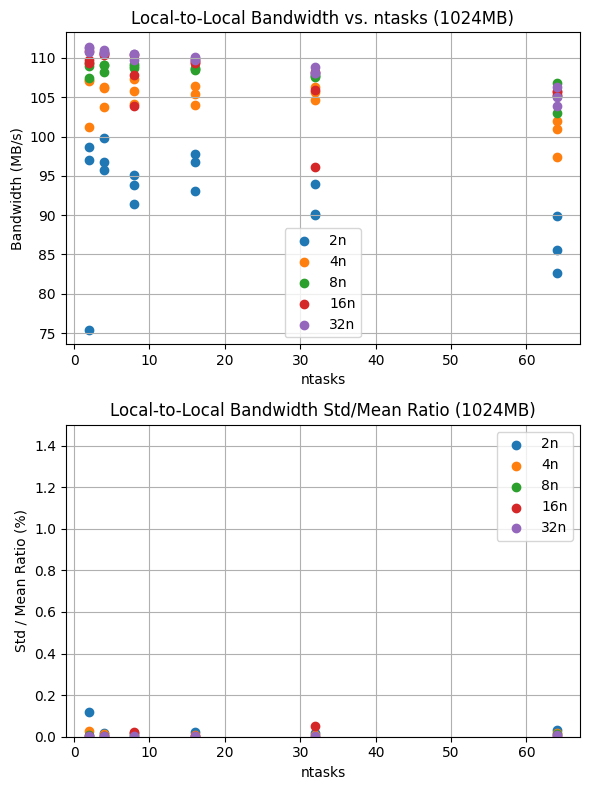

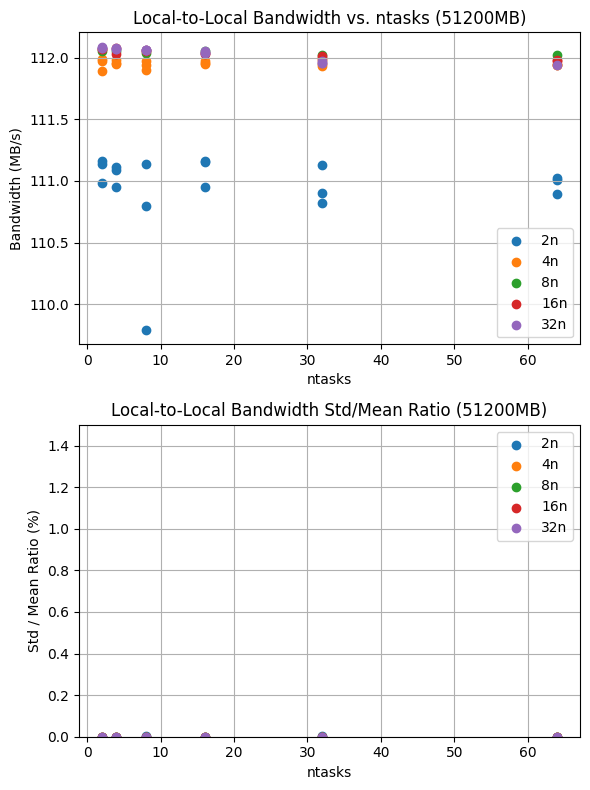

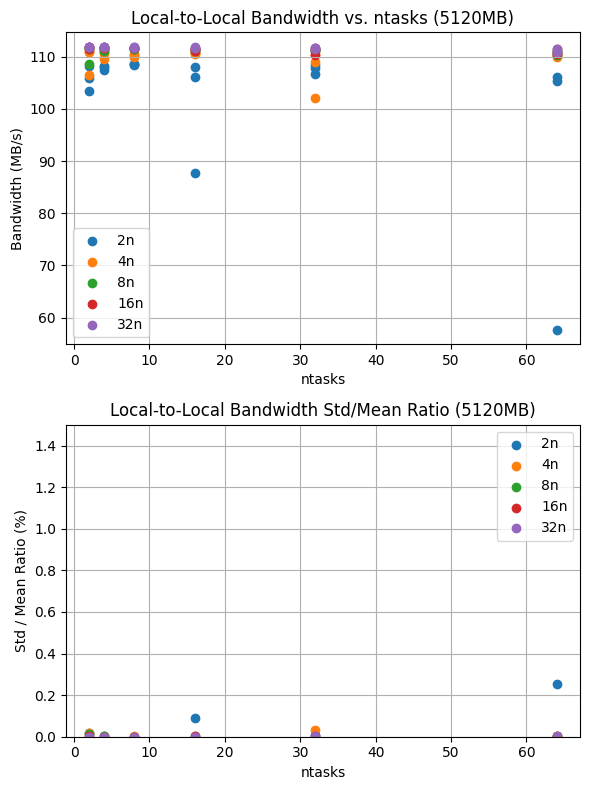

In [62]:
# /home/tang584/scripts/linux_resource_detect/update_average_values.py

import os
import re
import json
import matplotlib.pyplot as plt

filenames = [f for f in os.listdir() if f.startswith("tmpfs_to_tmpfs_") and f.endswith(".out")]
data = {}

for filename in filenames:
    match = re.search(r'_(\d+)n_', filename)
    if not match:
        continue
    node_count = int(match.group(1))
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('{'):
                record = json.loads(line)
                filesize = record.get("filesize")
                if not filesize:
                    continue
                if filesize not in data:
                    data[filesize] = {}
                if node_count not in data[filesize]:
                    data[filesize][node_count] = {"ntasks": [], "local-to-local": []}
                for trial_key, entry in record.items():
                    if trial_key == "filesize":
                        continue
                    data[filesize][node_count]["ntasks"].append(entry["ntasks"])
                    data[filesize][node_count]["local-to-local"].append(entry["local-to-local-bw(MB/s)"])

# Calculate averages and standard deviations
import numpy as np
averages = {}
std_devs = {}
for filesize, nodes in data.items():
    averages[filesize] = {}
    std_devs[filesize] = {}
    for node_count, metrics in nodes.items():
        averages[filesize][node_count] = {
            "local-to-local": np.mean(metrics["local-to-local"]) if metrics["local-to-local"] else 0,
        }
        std_devs[filesize][node_count] = {
            "local-to-local": np.std(metrics["local-to-local"])/np.mean(metrics["local-to-local"]) if metrics["local-to-local"] else 0,
        }

# Plotting
for filesize in sorted(data.keys()):
    # Plot shared-to-local: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["local-to-local"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Local-to-Local Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    # for node in sorted(data[filesize].keys()):
    #     unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
    #     std_values = []
    #     for ntask in unique_ntasks:
    #         indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
    #         std_values.append(np.std([data[filesize][node]["local-to-local"][i] for i in indices]))
    #     ax2.scatter(unique_ntasks, std_values, label=f"{node}n")
    # ax2.set_xlabel("ntasks")
    # ax2.set_ylabel("Standard Deviation")
    # ax2.set_title(f"Local-to-Local Bandwidth Standard Deviation ({filesize})")
    # ax2.legend()
    # ax2.grid(True)
    # ax2.set_ylim(0, 50000)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["local-to-local"][i] for i in indices]
            std_ratio = np.std(values) / np.mean(values) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Local-to-Local Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 1.5)

    plt.tight_layout()


In [63]:
import pandas as pd

IOR_PARAMS = [
    'operation', 'randomOffset', 'transferSize', 
    'aggregateFilesizeMB', 'numTasks', 'totalTime', 
    'numNodes', 'tasksPerNode', 'parallelism', 'trMiB', "storageType"
]

rows = []

for filesize, nodes in data.items():
    filesize_mb = int(filesize.replace("MB", ""))
    for num_nodes, metrics in nodes.items():
        ntasks_list = metrics['ntasks']
        local_bw_list = metrics['local-to-local']
        for i in range(len(ntasks_list)):
            ntasks = ntasks_list[i]
            # Local-to-shared (write)
            rows.append({
                'operation': 'write',
                'randomOffset': None,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': None,
                'trMiB': local_bw_list[i],
                'storageType': 'ssd-ssd'
            })
            
data_df = pd.concat([data_df, pd.DataFrame(rows, columns=IOR_PARAMS)], ignore_index=True)


print(data_df.head(5))

  operation randomOffset  transferSize  aggregateFilesizeMB  numTasks  \
0      read         None          4096                 1024         2   
1     write         None          4096                 1024         2   
2      read         None          4096                 1024         4   
3     write         None          4096                 1024         4   
4      read         None          4096                 1024         8   

   totalTime  numNodes  tasksPerNode parallelism    trMiB storageType  
0         -1         1             2        None  1544.56  beegfs-ssd  
1         -1         1             2        None  1095.59  ssd-beegfs  
2         -1         1             4        None  2724.01  beegfs-ssd  
3         -1         1             4        None  1981.16  ssd-beegfs  
4         -1         1             8        None  4972.14  beegfs-ssd  


In [64]:
print(data_df.shape)

(2008, 11)
